In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import numpy as np 
import os, glob
import matplotlib
from astropy.io import ascii
from matplotlib import rc
from scipy import stats
from astropy.coordinates import SkyCoord

np.seterr(invalid='ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


data_dir = os.getenv("DATADIR")
directory = data_dir + '/0_SUMS_Catalogs/CandidateCatalog/'

df = pd.read_csv(directory+'2_sed_reduced.csv')

# Results of SED Reduction
print('Cut after SED Reductions: ', df[~df.cut.isna()].shape[0])
print('Remain after SED Reductions: ', df[df.cut.isna()].shape[0])
print('Remain after SED Reductions in the LMC: ', df[(df.cut.isna()) & (df.galaxy == 'lmc')].shape[0])
print('Remain after SED Reductions in the SMC: ', df[(df.cut.isna()) & (df.galaxy == 'smc')].shape[0])

# Drop anything that was cut from the sample
df = df[df.cut.isna()]

Cut after SED Reductions:  8159
Remain after SED Reductions:  5184
Remain after SED Reductions in the LMC:  3130
Remain after SED Reductions in the SMC:  2054


In [2]:
# Drop any unnamed columns
df = df.drop([col for col in df.columns if 'Unnamed' in col], axis=1)

# Reset the index
df = df.reset_index(drop=True)

# Replace number columns that have nans with 0
nan_cols = ['uvw2_num2p5', 'uvm2_num2p5', 'uvw1_num2p5','uvw2_num1', 'uvm2_num1', 'uvw1_num1']
[df.fillna({col:0}, inplace=True) for col in nan_cols]

# Add a column taking maximum number of neighbors within 2.5"
df['max_2p5'] = df[['uvw2_num2p5', 'uvm2_num2p5', 'uvw1_num2p5']].max(axis=1)

# Add a column taking maximum number of neighbors are within 1"
df['max_1'] = df[['uvw2_num1', 'uvm2_num1', 'uvw1_num1']].max(axis=1)

# Add a column taking minimum distance of closest stars:
df['closest'] = df[['uvw2_closest_min', 'uvm2_closest_min', 'uvw1_closest_min']].min(axis=1)

# Add a column taking minimium and average of the UV flux fractions:
df['ff_min'] = df[['uvw2_flux_frac', 'uvm2_flux_frac', 'uvw1_flux_frac']].min(axis=1)
df['ff_avg'] = df[['uvw2_flux_frac', 'uvm2_flux_frac', 'uvw1_flux_frac']].mean(axis=1)

# Add a column for how many filters are present 
sed_columns = ['uvw2_dered','uvm2_dered','uvw1_dered','U_dered','B_dered','V_dered','I_dered']
df['n_filters'] = df[sed_columns].notna().sum(axis=1)

# Average distance from zams 
color_labels = ['uvw2 - b','uvw2 - v', 'uvw2 - i', 
                'uvw1 - b', 'uvw1 - v','uvw1 - i', 
                'uvm2 - b', 'uvm2 - v', 'uvm2 - i']
distance_labels = [f'{color} distance' for color in color_labels]
df['avg_zdis'] = df[distance_labels].mean(axis=1)

# Average distance weighted by errors (zsigma)
for col in color_labels:
    df[f'{col} zsigma'] = df[f'{col} distance'] / df[f'{col} err']
zsigma_labels = [f'{color} zsigma' for color in color_labels]
df['avg_zsigma'] = df[zsigma_labels].mean(axis=1)

# Require that the source is blue in at least three color combinations
n_rows = df.shape[0]

df = df[df.n_blue>3]

print('N Lost: ', n_rows - df.shape[0])
print(' ')
n_rows = df.shape[0]
# Require that the flux fraction is above 10%
df = df[df.ff_avg>0.1]

# If the closest source is within 2.5", require that the flux fraction be above 25%
df = df.drop(df[(df.closest<2.5) & (df.ff_avg<0.25)].index)

df = df.reset_index(drop=True)

# Replace the key 
df['key'] = np.arange(len(df))

print('Lost from Flux Fraction Cuts: ', n_rows - df.shape[0])

print('After initial cuts: ', df.shape[0])
print('In the LMC: ', df[df.galaxy == 'lmc'].shape[0])
print('In the SMC: ', df[df.galaxy == 'smc'].shape[0])

N Lost:  2518
 
Lost from Flux Fraction Cuts:  1783
After initial cuts:  883
In the LMC:  571
In the SMC:  312


# GAIA CUT 

In [3]:
#### NO GAIA DATA ####
df['No Gaia Data'] = 'False'
# ✨ Check if phot_g_mean_mag is within 1.5 mag of V band, if that is available, otherwise use B band.
# Phot_g_mean_mag is the Gaia G band magnitude. It is in the Vega system and needs to be converted to AB. 
# These values are from Table 5.2 https://gea.esac.esa.int/archive/documentation/GEDR3/Data_processing/chap_cu5pho/cu5pho_sec_photProc/cu5pho_ssec_photCal.html
ZP_AB = 25.8010
ZP_Vega = 25.6874
df['phot_g_mean_mag_AB'] = df['phot_g_mean_mag'] - (ZP_AB - ZP_Vega)
mcps_filter = []
no_mcps_filter_counter = 0
for ind, row in df.iterrows():
    if ~np.isnan(row['e_V']):
        mcps_filter.append(row['V'])
    elif ~np.isnan(row['e_B']):
        mcps_filter.append(row['B'])
    else:
        mcps_filter.append(np.nan)
        no_mcps_filter_counter += 1

# Note: Gaia px/pm cut is calculated in 2_CompileCatalog/5_compile_crossmatch.ipynb

# Calculate the difference in magnitudes between Gaia G and MCPS V or B band.
df['mag_diff'] = np.abs(df['phot_g_mean_mag_AB'] - mcps_filter)
df.loc[(df['mag_diff'].notna()) & (df['mag_diff'] > 1.5), 'No Gaia Data'] = 'True'
df.loc[df.pmra.isna(), 'No Gaia Data'] = 'True'

print('Candidates without Gaia Data: ', df[df['No Gaia Data'] == 'True'].shape[0])
print('Candidates with Gaia Data: ', df[df['No Gaia Data'] == 'False'].shape[0])
print('Candidates with GOF > 3: ', df[df['astrometric_gof_al'] > 3].shape[0])

# Require that the gaia checks are set to 'no'
# How many potential candidates will be cut by gaia? 
px_cut = df[(df['gaia_px_cut'] == 'yes') & (df['No Gaia Data'] == 'False')].shape[0]
df = df[df["gaia_px_cut"] == "no"]
pm_cut = df[(df['gaia_pm_cut'] == 'yes') & (df['No Gaia Data'] == 'False')].shape[0]
both_cut = df[(df['gaia_px_cut'] == 'yes') & (df['gaia_pm_cut'] == 'yes') & (df['No Gaia Data'] == 'False')].shape[0]
print('Candidates cut by parallax requirement: ', px_cut,' or ', round(px_cut/df.shape[0]*100, 2), '%')
print('Candidates cut by proper motion requirement: ', pm_cut,' or ', round(pm_cut/df.shape[0]*100, 2), '%')
print('Candidates cut by both parallax and proper motion requirement: ', both_cut,' or ', round(both_cut/df.shape[0]*100, 2), '%')


df = df[df["gaia_pm_cut"] == "no"].reset_index(drop=True)

print('Candidates with Gaia Data that passed the cuts: ', df[df['No Gaia Data'] == 'False'].shape[0])
print('Candidates with Gaia Data that passed the cuts: ', df[df['No Gaia Data'] == 'False'].shape[0]/df.shape[0] * 100, '%')

Candidates without Gaia Data:  62
Candidates with Gaia Data:  821
Candidates with GOF > 3:  176
Candidates cut by parallax requirement:  19  or  2.2 %
Candidates cut by proper motion requirement:  44  or  5.09 %
Candidates cut by both parallax and proper motion requirement:  0  or  0.0 %
Candidates with Gaia Data that passed the cuts:  758
Candidates with Gaia Data that passed the cuts:  92.4390243902439 %


# Very Blue vs Blue 
Split into two groups based on average distance from the ZAMS.  
Anything with a distance more than zdis_cut is considered very blue, otherwise it is just blue.  


# Excellent vs Good
Split into two groups based on the average flux fraction, bumpiness of the sed, and number of filters 

A source is considered excellent if all of the below conditions are true:
- (i) ff_avg is greater than ff_cut 
- (ii) there are one or fewer "bumps" in the SED
- (iii) there are 6 or more filters present.  

In [4]:
ff_cut = 0.4
zdis_cut = -0.4
bump_cut = 2
nfilter_cut = 6

df.loc[df.avg_zdis < zdis_cut, 'cut'] = 'VB-G'

df.loc[(df.avg_zdis < zdis_cut) & 
       (df.ff_avg > ff_cut) &
       (df.n_bumps <= 1) & 
       (df.n_filters >= nfilter_cut), 'cut'] = 'VB-E'

df.loc[df.avg_zdis >= zdis_cut, 'cut'] = 'B-G'

df.loc[(df.avg_zdis >= zdis_cut) & 
       (df.ff_avg > ff_cut) &
       (df.n_bumps <= 1) & 
       (df.n_filters >= nfilter_cut), 'cut'] = 'B-E'



In [5]:
# Read in the full catalog so we can assign the correct SUMS_ID
full_df = pd.read_csv(data_dir + "0_SUMS_Catalogs/FinalCatalogs/SUMS_UV_Catalog.csv")
full_coords = SkyCoord(ra=full_df['RA'], dec=full_df['Dec'], unit='deg')


# Sort by RA
df = df.sort_values(by='ra').reset_index(drop=True)

# Add ID Column 
candidate_coords = SkyCoord(ra=df['ra'], dec=df['dec'], unit='deg')
sums_ids = []
for coord in candidate_coords:
    sep = coord.separation(full_coords).arcsec
    min_sep = np.min(sep)
    if min_sep > 0.3:
        print('Warning: No match found')
    idx = np.argmin(sep)
    sums_ids.append(full_df['SUMS_ID'].iloc[idx])

df['SUMS_ID'] = sums_ids

# Save file 
df.to_csv(directory+'3_stripped_star_candidates.csv', index=False)


print(' ')
print('LMC Values: ')
print(df[df.galaxy == 'lmc'].cut.value_counts().sort_index())
print(' ')
print('SMC Values: ')
print(df[df.galaxy == 'smc'].cut.value_counts().sort_index())
print('Total Number LMC: ', df[df.galaxy == 'lmc'].shape[0])
print('Total Number SMC: ', df[df.galaxy == 'smc'].shape[0])
print('Total Number: ', df.shape[0])

 
LMC Values: 
cut
B-E      91
B-G     118
VB-E     78
VB-G    235
Name: count, dtype: int64
 
SMC Values: 
cut
B-E      91
B-G     104
VB-E     27
VB-G     76
Name: count, dtype: int64
Total Number LMC:  522
Total Number SMC:  298
Total Number:  820


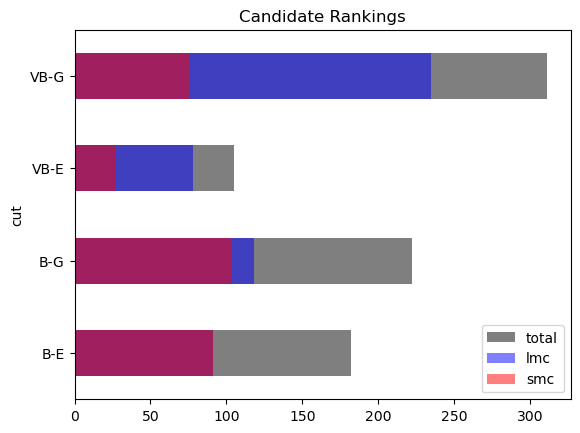

In [6]:
plt.title('Candidate Rankings')
df.cut.value_counts().sort_index().plot.barh(color='k',alpha=0.5,label='total');
df[df.galaxy == 'lmc'].cut.value_counts().sort_index().plot.barh(color='b',alpha=0.5,label='lmc');
df[df.galaxy == 'smc'].cut.value_counts().sort_index().plot.barh(color='r',alpha=0.5,label='smc')
plt.legend();